# **TOXIC COMMENT CLASSIFICATION - BASELINE MODELS**

<font color = 'blue'>

1. [Taxonomy of Text Classification](#1)    
2. [Read and Check Data](#2)
3. [Preprocessing](#3)
4. [TF-IDF Vectorizer](#4)
5. [Modelling and Evaluation](#5)
    * [Logistic Regression](#6)
    * [Multinomial NB](#7)
    * [LinearSVC](#8)
6. [What's Next?](#9)

<font size="+2" color="black"><b> Taxonomy of Text Classification </b></font><br><a id="1"></a>

Text classification can be distinguished into three types based on the number of categories involved: **binary, multiclass and multilabel** classification. In multi-class classification, we have one basic assumption that our data can belong to only one label out of all the labels we have.
In multi-label classification, data can belong to more than one label simultaneously. For example, in our case a comment might be toxic, obscene and insulting at the same time.

**It is a multi-label classification problem.** In Toxic Comment Classification EDA notebook, I tried to gain some useful insights from data which would aid further problem solving.

The next step is to **preprocess** the raw text and **transform it into feature vectors.**

And after that, I will select **the baseline model** for classification.

In [ ]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing
import re
import string
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from scipy.sparse import hstack

#Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import log_loss, roc_auc_score,roc_curve,auc,confusion_matrix

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


<font size="+2" color="black"><b> Read and Check Data </b></font><br><a id="2"></a>

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
train[labels] = train[labels].astype(np.int8)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


<font size="+2" color="black"><b> Preprocessing </b></font><br><a id="3"></a>


Before fitting models, we need to break down the sentence into unique words by tokenizing the comments.First of all, I rewrite the two words that each contraction stands for (i.e. won't -> will not), and the meanings that express the emojis. In the tokenize() function, I remove punctuations and special characters. I Also filtered out non-ascii characters and then lemmatized the comments and filtered out comments with length below 3. Besides these preprocessing steps, I tried stemming and tried to remove stopwords but did not get a better result.


In [ ]:
appo = {
"aren't" : "are not",
"can't" : "can not",
"couldn't" : "could not",
"didn't" : "did not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "i would",
"i'd" : "i had",
"i'll" : "i will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't" : "was not",
"we'll" : " will",
"tryin'" : "trying",
"yay!" : " good ",
"yay" : " good ",
"yaay" : " good ",
"yaaay" : " good ",
"yaaaay" : " good ",
"yaaaaay" : " good ",
":/" : " bad ",
":&gt;" : " sad ",
":')" : " sad ",
":-(" : " frown ",
":(" : " frown ",
":s": " frown ",
":-s": " frown ",
"&lt;3": " heart ",
":d": " smile ",
":p": " smile ",
":dd": " smile ",
"8)": " smile ",
":-)": " smile ",
":)": " smile ",
";)": " smile ",
"(-:": " smile ",
"(:": " smile ",
":/": " worry ",
":&gt;": " angry ",
":')": " sad ",
":-(": " sad ",
":(": " sad ",
":s": " sad ",
":-s": " sad ",
r"\br\b": "are",
r"\bu\b": "you",
r"\bhaha\b": "ha",
r"\bhahaha\b": "ha",
r"\bdon't\b": "do not",
r"\bdoesn't\b": "does not",
r"\bdidn't\b": "did not",
r"\bhasn't\b": "has not",
r"\bhaven't\b": "have not",
r"\bhadn't\b": "had not",
r"\bwon't\b": "will not",
r"\bwouldn't\b": "would not",
r"\bcan't\b": "can not",
r"\bcannot\b": "can not",
r"\bi'm\b": "i am",
"m": "am",
"r": "are",
"u": "you",
"haha": "ha",
"hahaha": "ha",
"doesn't": "does not",
"cannot": "can not",
"its" : "it is",
"'s" : " is",
"d'aww!":"cute"
}

In [ ]:
keys = [i for i in appo.keys()]

new_train_data = []
ltr = train["comment_text"].tolist()
for i in ltr:
    arr = str(i).split()
    xx = ""
    for j in arr:
        j = str(j).lower()
        if j[:4] == 'http' or j[:3] == 'www':
            continue
        if j in keys:
            # print("inn")
            j = appo[j]
        xx += j + " "
    new_train_data.append(xx)

train["comment_text"] = new_train_data

In [ ]:
new_test_data = []
lte = test["comment_text"].tolist()

for i in lte:
    arr = str(i).split()
    xx = ""
    for j in arr:
        j = str(j).lower()
        if j[:4] == 'http' or j[:3] == 'www':
            continue
        if j in keys:
            # print("inn")
            j = appo[j]
        xx += j + " "
    new_test_data.append(xx)

test["comment_text"] = new_test_data


In [ ]:
def tokenize(text):
    nopunct = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]').sub(" ", text)
    words = nopunct.split(' ')
    # remove any non ascii
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

<font size="+2" color="black"><b> TF-IDF Vectorizer </b></font><br><a id="4"></a>

Python's scikit-learn can deal with numerical data. To convert the text data into numerical form, I will use TF-IDF Vectorizer.

I determined to use TF-IDF Vectorizer to scale down the impact of tokens that occur frequently in a given corpus and hence less informative than features that occur in a small piece of the training corpus.

Besides TF-IDF, I used CountVectorizer. However, it did not perform as well as TF-IDF.

The TfidfVectorizer is equivalent to CountVectorizer followed by TfidfTransformer. TfidfTransformer transforms a count matrix to a normalized Term-Frequency or Term Frequency-Inverse Document Frequency representation.

For example the words such as 'the','and' are very common. But for our classification purposes they do not provide us useful information and that should probably be the reason why TFIDF worked better than CountVectorizer.

Character based vectorization: each character is considered an individual unit, and tokens are made up of character n-grams.

In [ ]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    tokenizer= tokenize,
    stop_words='english',
    ngram_range=(1, 1),
    use_idf=1,
    min_df=10)
train_word_features = word_vectorizer.fit_transform(train['comment_text'])
test_word_features = word_vectorizer.transform(test['comment_text'])
print(train_word_features.shape)

In [ ]:
print(word_vectorizer.get_feature_names()[50:60])

['abrupt', 'abruptly', 'absence', 'absent', 'absolute', 'absolutely', 'absolutly', 'absorb', 'absorbed', 'absorption']


In [ ]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)
train_char_features = char_vectorizer.fit_transform(train['comment_text'])
test_char_features = char_vectorizer.transform(test['comment_text'])

In [ ]:
train_features = hstack([train_char_features, train_word_features]).tocsr()
test_features = hstack([test_char_features, test_word_features]).tocsr()

In [ ]:
del(train_char_features)
del(test_char_features)
del(train_word_features)
del(test_word_features)

<font size="+2" color="black"><b> Modelling and Evaluation </b></font><br><a id="5"></a>

<font size="+1" color="black"><b> Selecting a Baseline Model </b></font><br><a ></a>
Algorithms like naive bayes, support vector machines, logistic regression perform well in text classification. I want to compare these models and choose the best one as my baseline model.

<font size="+1" color="black"><b> Evaluation Metric </b></font><br><a ></a>
Since this is a multi-label classification problem, a prediction containing a subset of the actual classes should be considered better than a prediction that contains none of them, i.e., predicting two of the three labels correctly this is better than predicting no labels at all.

The kaggle competition suggested the  mean column-wise ROC AUC. This is actually the mean of AUC for ROC curve of each type of toxicity, which is kind of average performance of the classifier across all six types of toxicities.



In [ ]:
#to plot a confusion matrix for each label
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Greens')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

I use cross Validation to compare models.

<font size="+1" color="black"><b> Logistic Regression </b></font><br><a id="6"></a>

CV score for class toxic is 0.9789661739954925


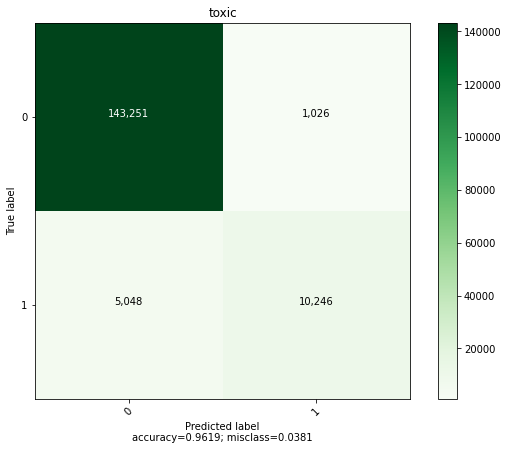

CV score for class severe_toxic is 0.9883586323737058


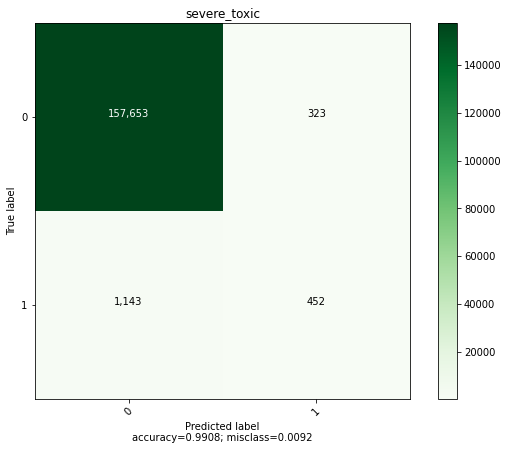

CV score for class obscene is 0.9896225341555606


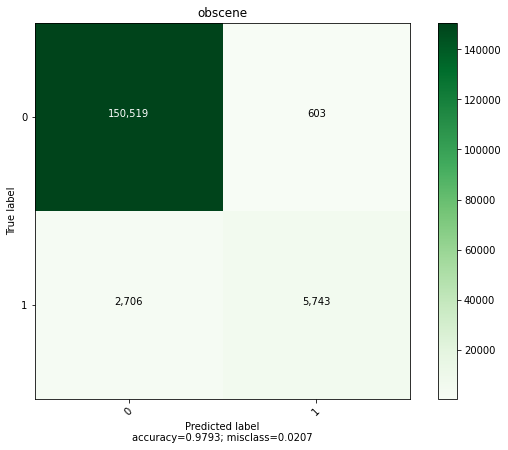

CV score for class threat is 0.9901641552257298


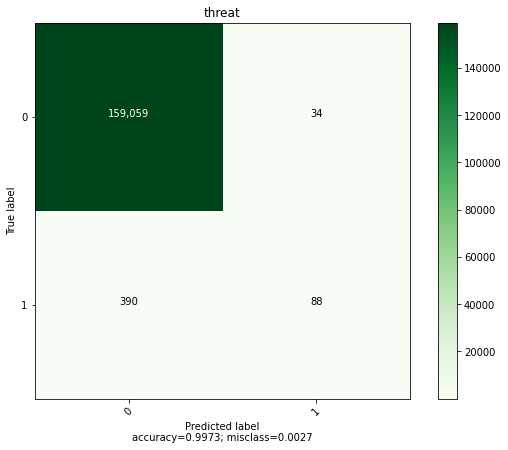

CV score for class insult is 0.983283556540815


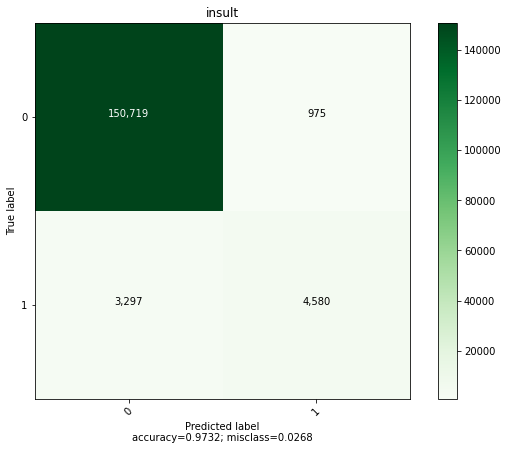

CV score for class identity_hate is 0.9834515870318916


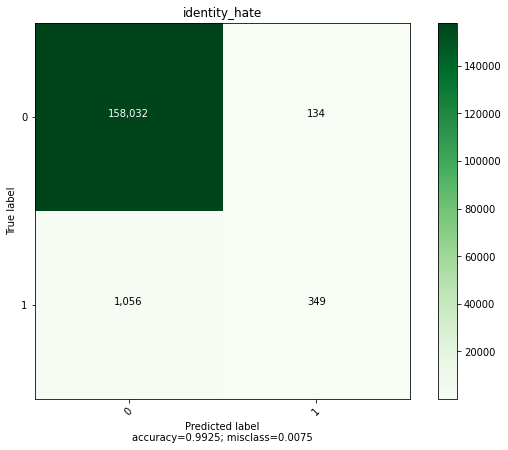

Total CV score is 0.9856411065538658


In [ ]:
scores = []

for class_name in labels:
    train_target = train[class_name]

    classifier = LogisticRegression()

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)

    predictions=cross_val_predict(classifier,train_features,train_target,cv=3)

    conf_mat = confusion_matrix(train_target,predictions)

    plot_confusion_matrix(cm = conf_mat,
                      normalize    = False,
                      target_names = ['0','1'],
                      title        = class_name)

print('Total CV score is {}'.format(np.mean(scores)))


We see the roc auc score and confusion matrices of each label. For example, 2706 comments with obscene content were predicted as not obscene and 603 comments with no obscene content were predicted as obscene. Or. while 390 threatening comments were predicted as containing no threat, 34 non-threatening comments were predicted as threatening. It is not a good thing to have a large number of false negatives. It is very important to correctly predict threatening comments.

Overall AUC Score:0.9856

<font size="+1" color="black"><b> Multinomial Naive Bayes </b></font><br><a id="7"></a>

CV score for class toxic is 0.954740596787648


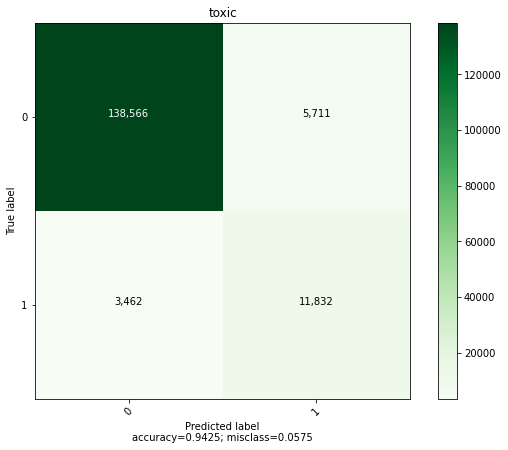

CV score for class severe_toxic is 0.966538034679424


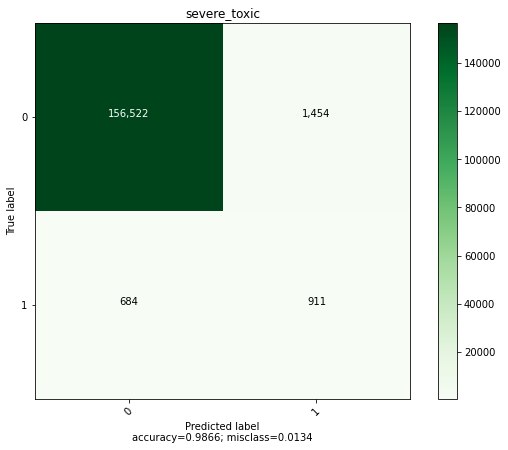

CV score for class obscene is 0.9612633262713679


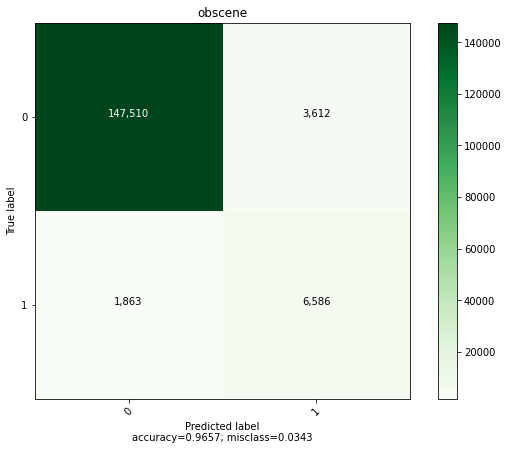

CV score for class threat is 0.8844571648680075


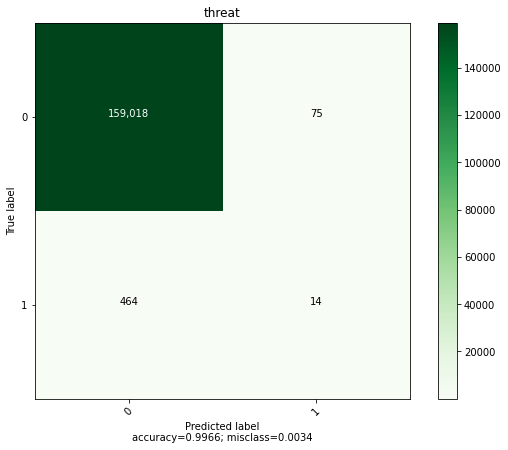

CV score for class insult is 0.9610586578636174


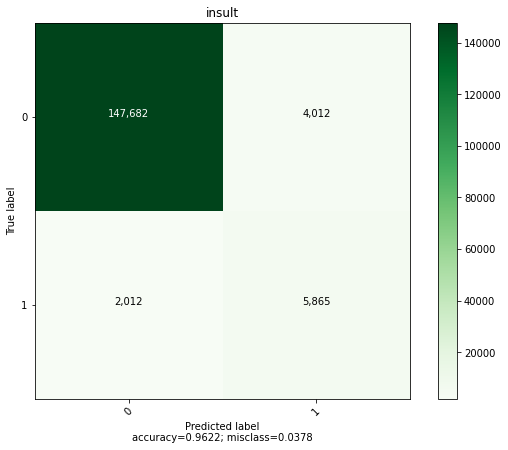

CV score for class identity_hate is 0.9215188528780818


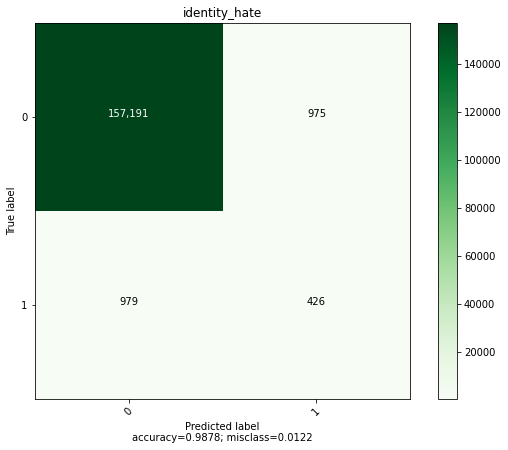

Total CV score is 0.9415961055580245


In [ ]:
scores = []

for class_name in labels:
    train_target = train[class_name]

    classifier = MultinomialNB()

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)

    predictions=cross_val_predict(classifier,train_features,train_target,cv=3)

    conf_mat = confusion_matrix(train_target,predictions)

    plot_confusion_matrix(cm = conf_mat,
                          normalize    = False,
                          target_names = ['0','1'],
                          title        = class_name)

print('Total CV score is {}'.format(np.mean(scores)))

If we look at the threat label again, while 464 threatening comments were predicted as containing no threat, 75 non-threatening comments were predicted as threatening. And overall auc score is 0.9415.

We can say that, **Multinomial NB made a worse prediction than logistic regression on the validation set.**

<font size="+1" color="black"><b>  LinearSVC </b></font><br><a id="8"></a>

CV score for class toxic is 0.9707487166613626


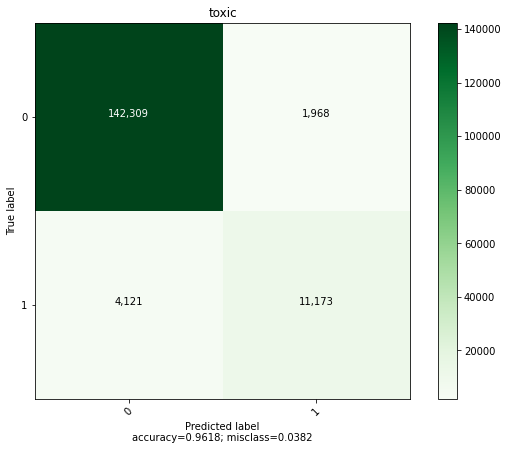

CV score for class severe_toxic is 0.9713111159470807


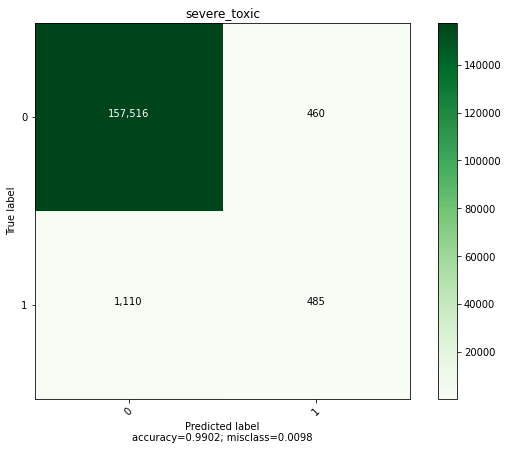

CV score for class obscene is 0.981611500200566


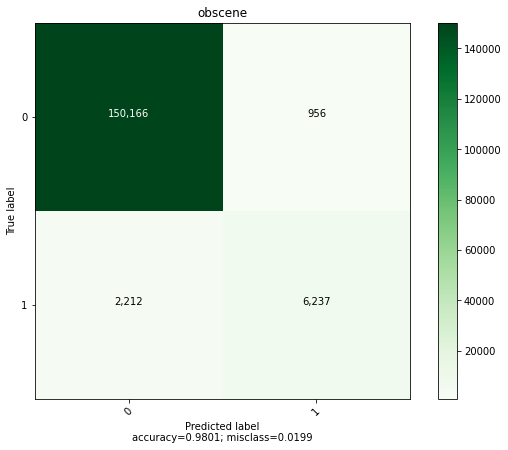

CV score for class threat is 0.9777945316793266


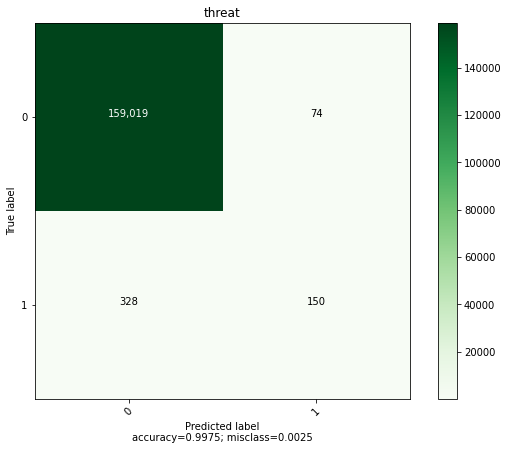

CV score for class insult is 0.9700318593543168


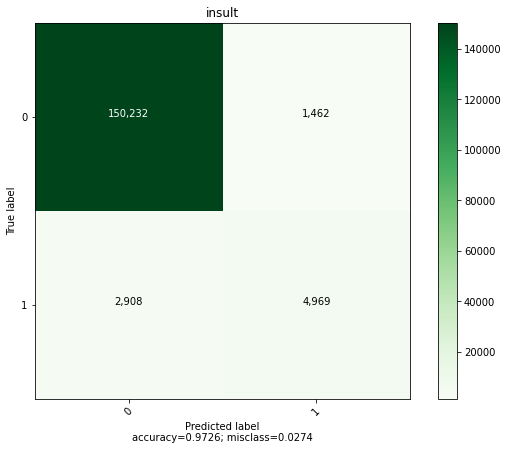

CV score for class identity_hate is 0.9672420942826129


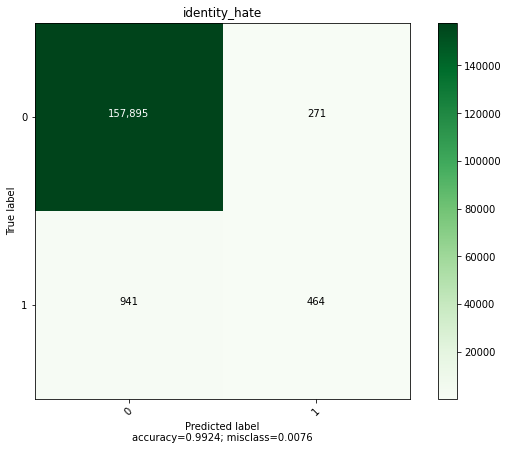

Total CV score is 0.9731233030208776


In [ ]:
scores = []

for class_name in labels:
    train_target = train[class_name]

    classifier = LinearSVC()

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)

    predictions=cross_val_predict(classifier,train_features,train_target,cv=3)

    conf_mat = confusion_matrix(train_target,predictions)

    plot_confusion_matrix(cm = conf_mat,
                          normalize    = False,
                          target_names = ['0','1'],
                          title        = class_name)

print('Total CV score is {}'.format(np.mean(scores)))

If we look at the threat label again, while 328 threatening comments were predicted as containing no threat, 74 non-threatening comments were predicted as threatening. And overall auc score is 0.9731.

**LinearSVC predicted almost as well as logistic regression on the validation set.**

<font size="+2" color="black"><b>  What's Next? </b></font><br><a id="8"></a>

There are many multi-label classification approaches such as **OneVsRest, Binary Relevance, Classifier Chains** etc. I will experiment with **Logistic Regression** classifier using **OneVsRest** approaches for solving the multi-label classification problem.